*** Begin table output for tas_land ***
      count      mean       std       min       10%       50%       90%  \
2010   35.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020   35.0  0.314494  0.264136 -0.140642  0.018143  0.294783  0.759458   
2030   35.0  0.620317  0.279993  0.053183  0.295545  0.616758  1.021700   
2040   35.0  0.948630  0.335472  0.179775  0.551708  0.954317  1.431623   
2050   35.0  1.363628  0.598078  0.256667  0.477048  1.385567  2.126877   
2060   35.0  1.805962  0.874383  0.127117  0.603808  1.807925  2.885020   

           max  
2010  0.000000  
2020  0.895558  
2030  1.138783  
2040  1.622667  
2050  2.468025  
2060  3.309667  
*** End table output for tas_land ***
*** Begin table output for pr_land ***
      count      mean       std       min       10%       50%       90%  \
2010   35.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020   35.0  0.006441  0.131163 -0.293383 -0.161730  0.020125  0.189525   
2030   35.0 -

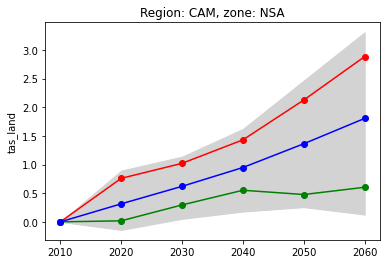

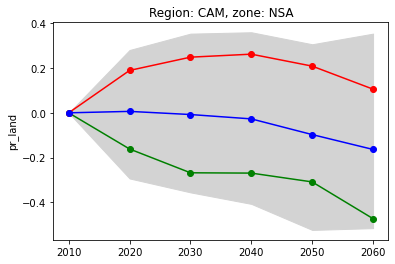

In [9]:
#import libraries 
import pandas as pd
import os
from matplotlib import pyplot as plt

def extract_data(datapath, zone, aggregate_by_decade=False):
    """
    extract data for a particular subzone and make annual aggregation   
    returns annually aggregated dataframe

    """

    #prepare output dataframe
    time_index = pd.date_range(start="1970-01-01", end="2100-01-01", freq='AS')
    out = pd.DataFrame(index=time_index)

    #extract data and do annual aggregation
    for f in os.listdir(datapath):
        df = pd.read_csv(os.path.join(datapath, f), header=15, usecols=['date', zone])
        df['date']  = pd.to_datetime(df['date'], format="%Y-%m", dayfirst=False)

        df.set_index(keys='date', drop=True, inplace=True)
        df_ann = df.resample(rule='AS').mean()
        out[f] = df_ann[zone]
    
    if aggregate_by_decade:
        out = out.groupby((out.index.year//10)*10).mean()

    return out
    
# region and subregion codes as per datasets-aggregated-regionally/README.md
region = "CAM"
zone = "NSA"

# list of parameters for analysis see Appendix B in  https://is-enes-data.github.io/cordex_archive_specifications.pdf
# future idea split zone land/sea and variable name
parameters = ["tas_land", "pr_land"]

for p in parameters:
    fig, ax = plt.subplots()
    #construct datapath from region and parameter inputs
    path = "../datasets-aggregated-regionally/data/CORDEX/CORDEX-{reg}_{param}".format(reg=region, param=p)
    
    # get the data by calling exctract_data function defined above
    df = extract_data(datapath=path, zone=zone, aggregate_by_decade=True)
    
    #trim output to 2010-2060
    df = df[(df.index >= 2010) & (df.index <= 2060)]
    
    #calculate deltas to 2010-2020 baseline (first row after trimming)
    df = df - df.iloc[0]

    #calculate statistics
    desc = df.T.describe(percentiles=[0.1, 0.9])
    desc = desc.T
    
    #plot
    ax.fill_between(desc.index, desc['min'], desc['max'], color='lightgrey')
    ax.plot(desc.index, desc['10%'], marker='o', color='green')
    ax.plot(desc.index, desc['90%'], marker='o', color='red')
    ax.plot(desc.index, desc['mean'], marker='o', color='blue')
    ax.set_title("Region: {reg}, zone: {zon}".format(reg=region, zon=zone))
    ax.set_ylabel(p)

    #table output
    print("*** Begin table output for {0} ***".format(p))
    print(desc)
    print("*** End table output for {0} ***".format(p))
